<a href="https://colab.research.google.com/github/justinfmccarty/urban_bipv_annotated_bib/blob/main/notebooks/bipv_lit_rev_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Literature Clusters for BIPV

This notebook is a replication of an effort to cluster COVID-19 publications:

Eren, Maksim Ekin, Nick Solovyev, Edward Raff, Charles Nicholas, and Ben Johnson. “COVID-19 Kaggle Literature Organization.” In Proceedings of the ACM Symposium on Document Engineering 2020, 1–4. DocEng ’20. New York, NY, USA: Association for Computing Machinery, 2020. https://doi.org/10.1145/3395027.3419591.

Using the database engine "lens.org" I have extracted building integrated photovoltaic literature to feed into Eren et al.'s clustering workflow.

A future effort will be done once I have access to the Lens API system and can gather a more comprhensive dataset.



### Section 1: Load and Process Data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
url = r'https://github.com/justinfmccarty/urban_bipv_annotated_bib/blob/main/data/bipv_inclusive.csv?raw=true'
df_raw = pd.read_csv(url)
df_raw.sample(3)

In [ ]:
# for this notebook I am only getting journal articles
df_raw_j = df_raw[df_raw['Publication Type']=='journal article']
print(f'Original shape was {df_raw.shape}')
print(f'New shape is {df_raw_j.shape}')

In [ ]:
# remove publications without an abstract as this is key to the clustering effort
df_raw_j_clean = df_raw_j.dropna(subset=['Abstract'])
print(f'Original shape was {df_raw_j.shape}')
print(f'New shape is {df_raw_j_clean.shape}')
df_raw_j_clean.sample(2)

Original shape was (7391, 29)
New shape is (7132, 29)


,Lens ID,Title,Date Published,Publication Year,Publication Type,Source Title,ISSNs,Publisher,Source Country,Author/s,Abstract,Volume,Issue Number,Start Page,End Page,Fields of Study,Keywords,MeSH Terms,Chemicals,Funding,Source URLs,External URL,PMID,DOI,Microsoft Academic ID,PMCID,Citing Patents Count,References,Citing Works Count
7325,088-131-561-961-454,DC nanogrid for renewable sources with modular...,2017-02-16,2017.0,journal article,IET Power Electronics,17554543; 17554535,Institution of Engineering and Technology (IET),United Kingdom,Carlo Cecati; Hassan Abdullah Khalid; Mario Ti...,Centralised electricity systems are being inte...,10,5,536,544,Electrical engineering; Voltage source; Energy...,NaN,NaN,NaN,NaN,https://ieeexplore.ieee.org/document/7894943/ ...,http://dx.doi.org/10.1049/iet-pel.2016.0200,NaN,10.1049/iet-pel.2016.0200,2548982234,NaN,0,002-740-335-923-55X; 003-072-942-903-919; 009-...,24
2390,023-263-936-665-747,"Bifacial, color-tunable semitransparent perovs...",2019-12-20,2019.0,journal article,ACS applied materials & interfaces,19448252; 19448244,American Chemical Society,United States,Hao Wang; Herlina Arianita Dewi; Teck Ming Koh...,"Recently, semitransparent perovskite solar cel...",12,1,484,493,Building-integrated photovoltaics; Perovskite ...,BIPV; bifacial solar cell; colorful perovskite...,NaN,NaN,National Research Foundation Singapore; Nation...,https://pubs.acs.org/doi/10.1021/acsami.9b1548...,http://dx.doi.org/10.1021/acsami.9b15488,31814394,10.1021/acsami.9b15488,2996469781,NaN,0,006-207-723-814-646; 009-870-531-460-150; 012-...,21


In [ ]:
# there may be a need for publication year later on in visualization 
# so I will be dropping anything without a publication year

# lets see how many
print(f"Missing in Publication Year {len(df_raw_j_clean[df_raw_j_clean['Publication Year'].isnull()])}")
print(f"Missing in Date Published {len(df_raw_j_clean[df_raw_j_clean['Date Published'].isnull()])}")

df_raw_j_clean_years = df_raw_j_clean.dropna(subset=['Publication Year'])
print(f'Original shape was {df_raw_j_clean.shape}')
print(f'New shape is {df_raw_j_clean_years.shape}')

Missing in Publication Year 27
Missing in Date Published 4033
Original shape was (7132, 29)
New shape is (7105, 29)


In [ ]:
# simplify dataframe for clustering workflow

columns = ['Lens ID',
           'Title',
           'Publication Year',
           'Abstract',
           'External URL',
           'DOI',
           'Author/s']

df_raw_j_clean_sub = df_raw_j_clean_years[columns].astype({'Publication Year':'int32'})
df_raw_j_clean_sub = df_raw_j_clean_sub.rename(columns={'Lens ID':'lens_id',
                                                        'Title':'title',
                                                        'Publication Year':'year',
                                                        'Abstract':'abstract',
                                                        'External URL':'external_url',
                                                        'DOI':'doi',
                                                        'Author/s':'authors'})

df_raw_j_clean_sub.sample(3)


,lens_id,title,year,abstract,external_url,doi,authors
4036,042-663-516-810-524,Where the wicked problems are: The case of men...,2010,Abstract Objective To use system ideas and the...,http://dx.doi.org/10.1016/j.healthpol.2010.11.002,10.1016/j.healthpol.2010.11.002,Ben Hannigan; Michael Coffey
4116,043-683-034-743-917,Modelling of solar micro gas turbine for parab...,2020,Dish-Stirling unit and photovoltaic panels are...,http://dx.doi.org/10.12928/telkomnika.v18i6.16676,10.12928/telkomnika.v18i6.16676,Syariffah Othman; Mohd Ruddin Ab Ghani; Zanari...
3779,039-449-078-784-489,Design and Implementation of Multi-Directional...,2013,This paper introduces the design of the all-ro...,http://dx.doi.org/10.4028/www.scientific.net/a...,10.4028/www.scientific.net/amm.380-384.889,null De Jun Li; Zhi Hu


In [ ]:
# last check for any NaN values
for col in df_raw_j_clean_sub.columns:
  if df_raw_j_clean_sub[col].isnull().values.any():
    print(f'{col} contains NaN values.')
  else:
    pass

external_url contains NaN values.
doi contains NaN values.
authors contains NaN values.


In [ ]:
# ok so we may want to link back to papers at the end of this so let's see
# where links are missing

print(f"External URL NaN length is {len(df_raw_j_clean_sub[df_raw_j_clean_sub['external_url'].isnull()])}")
print(f"DOI NaN length is {len(df_raw_j_clean_sub[df_raw_j_clean_sub['doi'].isnull()])}")

External URL NaN length is 14
DOI NaN length is 266


In [ ]:
# only several missing so I will leave it now and come back with the API from Lens or Crossref 
# so we have the dataset ready for the clustering workflow

df_raw_j_clean_sub.sample(4)

,lens_id,title,year,abstract,external_url,doi,authors
481,004-316-714-454-503,Developing an optimal electricity generation m...,2016,The UK electricity sector is undergoing a tran...,http://dx.doi.org/10.1016/j.energy.2016.01.077,10.1016/j.energy.2016.01.077,H. Sithole; Tim Cockerill; Kevin J. Hughes; De...
8431,106-692-423-910-289,Technological Progress towards Sustainable Dev...,2002,"The purpose of this paper is twofold. First, t...",https://core.ac.uk/display/33898033,NaN,Ger Klaassen; Asami Miketa; Keywan Riahi; Leo ...
7786,095-715-703-331-291,Economic analysis of BIPV systems as a buildin...,2020,Abstract The main purpose of this study is to ...,http://dx.doi.org/10.1016/j.energy.2020.117931,10.1016/j.energy.2020.117931,Hassan Gholami; Harald N. Røstvik
7084,084-567-728-454-801,Evaluation of Combined Solar Thermal Heat Pump...,2014,Abstract This paper presents results from the ...,http://dx.doi.org/10.1016/j.egypro.2014.02.070,10.1016/j.egypro.2014.02.070,Werner Lerch; Andreas Heinz; Richard Heimrath


### Section 2: Clustering Workflow (Eren et al., 2020)

source: https://github.com/MaksimEkin/arXiv-Literature-Clustering/blob/master/arxiv_clustering.ipynb

#### Part A: Final Cleaning

In [ ]:
%%capture 
# need to install some things
!pip install langdetect

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from multiprocessing import Pool
import string


In [ ]:
# so we can skip the first few cells of the original notebook as they 
# read their data into df from the source json files in the Kaggle data

# We begin with the NLP 

df = df_raw_j_clean_sub.copy()

In [ ]:
# this processing was done in the larger COVID work around cell 18:
# https://github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/COVID19_literature_clustering.ipynb
# it is removing non english publications 

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each abstract
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['title'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in title...
        except Exception as e:
            
            try:
                # let's try to label it through the title then
                lang = detect(df.iloc[ii]['title'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

In [ ]:

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

In [ ]:

df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [ ]:
# ok so lets get rid of the non-english work
# this is a known issue with this process

df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6906 entries, 0 to 11476
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lens_id       6906 non-null   object
 1   title         6906 non-null   object
 2   year          6906 non-null   int32 
 3   abstract      6906 non-null   object
 4   external_url  6892 non-null   object
 5   doi           6657 non-null   object
 6   authors       6901 non-null   object
 7   language      6906 non-null   object
dtypes: int32(1), object(7)
memory usage: 458.6+ KB


In [ ]:
# back to https://github.com/MaksimEkin/arXiv-Literature-Clustering/blob/master/arxiv_clustering.ipynb
# stop words are common words that may complicate the analysis so we set up 
# a system to remove them


punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['now',
 'whose',
 'why',
 'just',
 '‘ve',
 'thereafter',
 'toward',
 'although',
 'if',
 'everywhere']

In [ ]:
# also adding in a few more common stop words 
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al',
    'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using',
    'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 
    'CZI', 'www','abstract', 'Abstract'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [ ]:
# Parser
parser = spacy.load("en_core_web_sm")
parser.max_length = 7000000

def call_tokenizer(df):
    df["processed_abstract"] = df["abstract"].apply(spacy_tokenizer)
    return df

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:

def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
import multiprocessing

print(multiprocessing.cpu_count()) # Count the number of cores in a computer


2


In [ ]:
%time df = parallelize_dataframe(df=df, func=call_tokenizer)

CPU times: user 1.93 s, sys: 1 s, total: 2.94 s
Wall time: 4min 4s


In [ ]:

file_name = "bipv_data.p"
# pickle.dump(df, open(file_name, "wb" ))

#### Part B: Clustering

In [ ]:

df_new = pickle.load(open(file_name, "rb"))

# next line is if we wanted a subset but this dataframe is small enough
# df_new = df_new.sample(600000)

In [ ]:

def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

text = df_new['processed_abstract'].values
%time X = vectorize(text, 2 ** 12)
X.shape

CPU times: user 674 ms, sys: 15.1 ms, total: 689 ms
Wall time: 701 ms


(6906, 4096)

In [ ]:
# here we begin the clustering process
# first the PCA for reduction  
# then detect the amount of clusters for k means

# PCA and cluster counts were done in the larger COVID notebook (cell 33)
# https://github.com/MaksimEkin/COVID19-Literature-Clustering/blob/master/COVID19_literature_clustering.ipynb


In [ ]:
pca = PCA(n_components=0.95, random_state=42)
%time X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

CPU times: user 3min 3s, sys: 4.81 s, total: 3min 7s
Wall time: 1min 36s


(6906, 2463)

In [ ]:
# TODO this needs to be parallelized

# nest both operations in one

distortions = []
sil = []
kmax = 50

for k in range(2, kmax):
  kmeans = KMeans(n_clusters = k).fit(X_reduced)
  labels = kmeans.labels_
  sil_calc = silhouette_score(X_reduced, labels, metric = 'euclidean')
  sil.append(sil_calc)
  print('Found silhouette score of {} for {} clusters'.format(sil_calc,k))
  distortion_calc = sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
  distortions.append(distortion_calc)
  print('Found distortion of {} for {} clusters'.format(distortion_calc,k))


In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

##### Deprecated Cluster Search

In [ ]:
# TODO This needs to be parallelized

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42, n_jobs=-1).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

In [ ]:


from sklearn.metrics import silhouette_score

sil = []
kmax = 50

# dissimilarity would not be defined for a single cluster, thus, 
# minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X_reduced)
  labels = kmeans.labels_
  sil.append(silhouette_score(X_reduced, labels, metric = 'euclidean'))



##### Back to Part B

In [ ]:
# looks like the optimal amount of clusters lie around...
clusters = 8

In [ ]:

kmeans = KMeans(n_clusters=clusters, random_state=42, n_jobs=-1)
%time y_pred = kmeans.fit_predict(X_reduced)
df_new['y'] = y_pred



CPU times: user 453 ms, sys: 142 ms, total: 595 ms
Wall time: 41.7 s


In [ ]:
df_new

In [ ]:
pickle.dump(df_new, open("bipv_data_clusters.p", "wb" ))

In [ ]:
# reduce dimensionality with t-SNE
df_new_clustered = pickle.load(open('/content/bipv_data_clusters.p', "rb"))


In [ ]:

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 6906 samples in 5.825s...
[t-SNE] Computed neighbors for 6906 samples in 407.673s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6906
[t-SNE] Computed conditional probabilities for sample 2000 / 6906
[t-SNE] Computed conditional probabilities for sample 3000 / 6906
[t-SNE] Computed conditional probabilities for sample 4000 / 6906
[t-SNE] Computed conditional probabilities for sample 5000 / 6906
[t-SNE] Computed conditional probabilities for sample 6000 / 6906
[t-SNE] Computed conditional probabilities for sample 6906 / 6906
[t-SNE] Mean sigma: 0.425145
[t-SNE] KL divergence after 250 iterations with early exaggeration: 124.535370
[t-SNE] KL divergence after 1000 iterations: 3.229272


In [ ]:
X_embedded[:100,1]

array([ 0.42951313,  3.2857206 , -1.3306602 , -1.4732246 ,  1.9429661 ,
        0.83130866,  7.045374  , -1.1073784 , -2.1088977 ,  1.2573361 ,
       -5.2396107 ,  3.7071044 ,  3.8161833 ,  0.6308096 ,  1.4313356 ,
       -4.07135   ,  2.0815837 , -0.1696251 ,  0.3938284 ,  1.3253666 ,
        0.42975044, -3.112204  ,  0.409303  , -2.720683  , -0.531851  ,
       -0.59063417, -2.3988287 , -1.4172381 ,  4.6652203 , -0.7889984 ,
        0.34914383, -1.5896753 , -2.0619574 , -4.0926633 , -0.88066024,
        0.15788463,  3.2496328 ,  3.8395267 , -1.6950767 , -0.18741022,
        0.92080027, -2.1321745 ,  2.699477  ,  5.583399  ,  1.1733629 ,
        1.35594   , -2.3041425 , -0.17879252,  0.06002162, -0.05055891,
       -2.3506818 , -1.031288  ,  0.1549158 , -3.1557126 , -5.6875243 ,
        4.3164387 ,  0.88921666,  5.128514  , -3.4758043 , -5.0647326 ,
       -2.6742196 , -3.1157317 , -4.2831807 , -2.2179577 , -3.680325  ,
       -1.7588892 , -5.620321  , -6.1464653 , -2.040592  ,  3.20

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


NameError: ignored

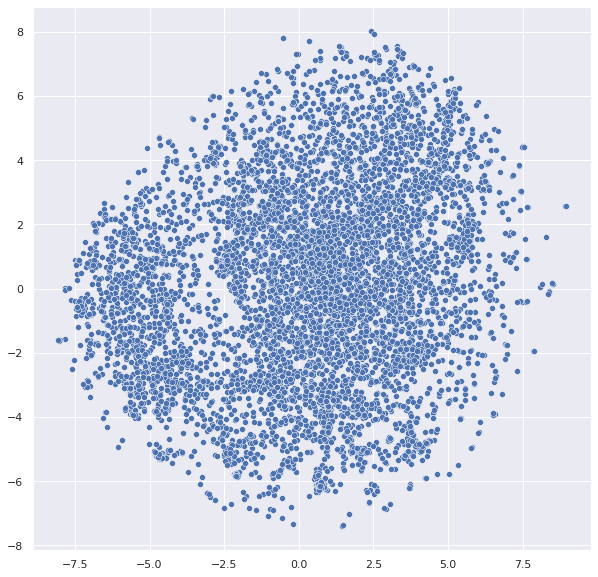

In [ ]:

# sns settings
sns.set(rc={'figure.figsize':(10,10)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
# plt.savefig("tsne_bipv.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


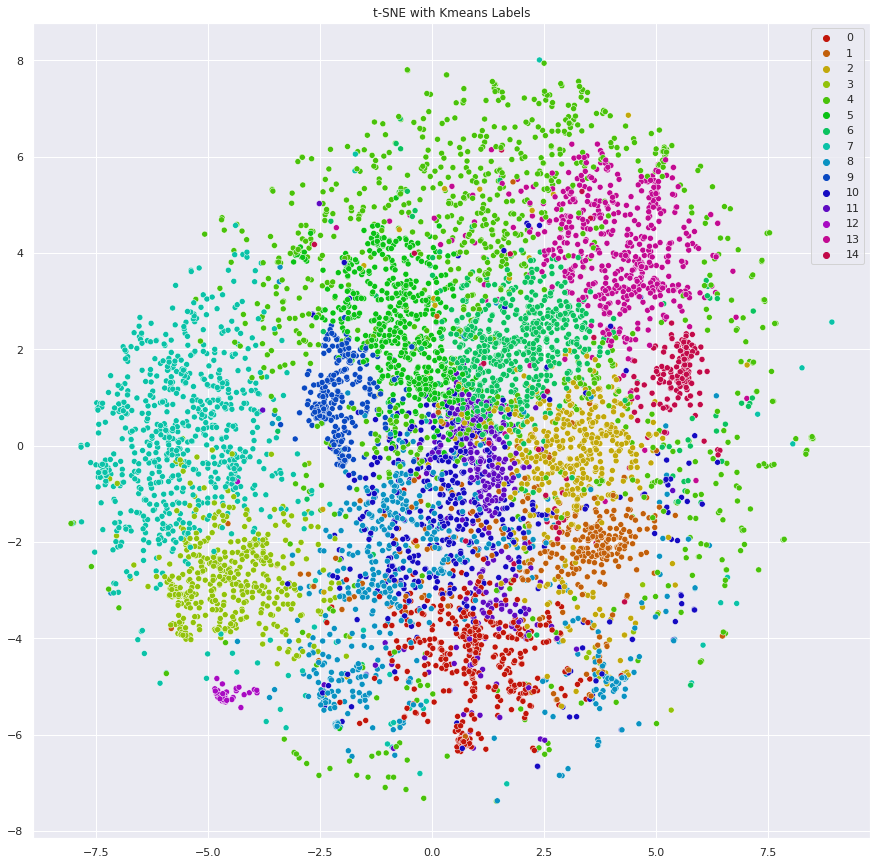

In [ ]:

# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(clusters, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("tsne_bipv_colored.png")
plt.show()

#### Part C: Labeling

In [ ]:
# now we attempt to label each of the clusters using the most common words

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizers = []
    
for ii in range(0, clusters):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df_new.loc[df_new['y'] == current_cluster, 'processed_abstract']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

len(vectorized_data)

20

In [ ]:
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, clusters):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, 
                                    max_iter=10, 
                                    learning_method='online',
                                    verbose=False, 
                                    random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [ ]:
# Extracts the keywords from each cluster
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [ ]:
# Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

AttributeError: ignored